In [1]:
#네이버 영화리뷰 감성분석

In [2]:
#1.데이터 준비와 확인

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import re
import matplotlib.pyplot as plt

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
#2. 데이터로더 구성

In [6]:
#nsmc 데이터셋의 텍스트를 가공하여 data_loader를 만들기.

1)데이터의 중복 제거
2)NaN 결측치 제거
3)한국어 토크나이저로 토큰화
4)불용어(Stopwords) 제거
5)사전word_to_index 구성
6)텍스트 스트링을 사전 인덱스 스트링으로 변환
7)X_train, y_train, X_test, y_test, word_to_index 리턴#

In [8]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [11]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index): 
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [15]:
X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train_post.shape)

(146182, 41)


In [16]:
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(146182, 41)


In [ ]:
#4. 모델 구성 및 validation set 구성

In [ ]:
#a. RNN 모델 (Recurrent Neural Network)

In [17]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용. 이때 LSTM state 벡터의 차원수는 8. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#b. CNN 모델

In [18]:
vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수. 

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim .

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
#c. GlobalMaxPooling1D() 레이어

In [19]:
# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수 

model_glob = tf.keras.Sequential()
model_glob.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_glob.add(tf.keras.layers.GlobalMaxPooling1D())
model_glob.add(tf.keras.layers.Dense(8, activation='relu'))
model_glob.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim .

model_glob.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#validation set 구성

In [20]:
# 훈련용 데이터셋 146182건 중 10000건을 분리하여 검증셋(validation set)으로 사용
X_val = X_train_pre[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train_pre[10000:]  
partial_y_train = y_train[10000:]

print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)
(136182, 41)
(136182,)


In [ ]:
#5. 모델 훈련 및 그래프

In [ ]:
#a-1 RNN 모델 훈련

In [21]:
# 모델 학습
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 22s 7ms/step - loss: 0.4834 - accuracy: 0.7754 - val_loss: 0.3517 - val_accuracy: 0.8502
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3345 - accuracy: 0.8590 - val_loss: 0.3381 - val_accuracy: 0.8529
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3150 - accuracy: 0.8686 - val_loss: 0.3378 - val_accuracy: 0.8519
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3016 - accuracy: 0.8752 - val_loss: 0.3375 - val_accuracy: 0.8534
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2901 - accuracy: 0.8804 - val_loss: 0.3412 - val_accuracy: 0.8521
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2790 - accuracy: 0.8859 - val_loss: 0.3428 - val_accuracy: 0.8552
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2692 - accuracy: 0.8915 - val_loss: 0.3490 - val_accuracy: 0.8529
Epoch

In [ ]:
#a-2 RNN 모델 Loss, Accuracy 그래프 시각화

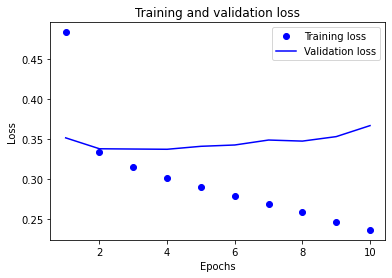

In [22]:
history_rnn_dict = history_rnn.history

# Training and validation loss 그래프 그리기
acc = history_rnn_dict['accuracy']
val_acc = history_rnn_dict['val_accuracy']
loss = history_rnn_dict['loss']
val_loss = history_rnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

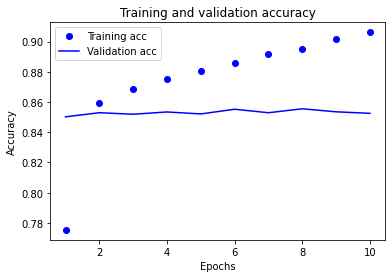

In [23]:
# Training and validation accuracy 그래프 그리기
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
a-3 RNN 모델의 test set 으로 평가

In [24]:
results = model_rnn.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3759 - accuracy: 0.8461
[0.3758605122566223, 0.8461053371429443]


In [ ]:
#b-1 CNN 모델 훈련

In [26]:
# 모델 학습
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 1s 6ms/step - loss: 0.1868 - accuracy: 0.9287 - val_loss: 0.4375 - val_accuracy: 0.8439
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1814 - accuracy: 0.9307 - val_loss: 0.4500 - val_accuracy: 0.8446
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1757 - accuracy: 0.9331 - val_loss: 0.4601 - val_accuracy: 0.8461
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1686 - accuracy: 0.9361 - val_loss: 0.4941 - val_accuracy: 0.8418
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1628 - accuracy: 0.9388 - val_loss: 0.4949 - val_accuracy: 0.8401


In [ ]:
b-2 CNN 모델 Loss, Accuracy 그래프 시각화

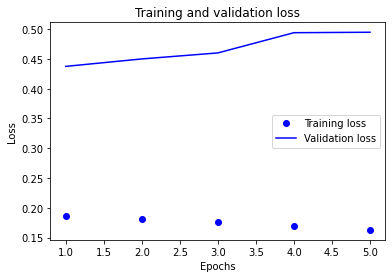

In [27]:
history_cnn_dict = history_cnn.history

# Training and validation loss 그래프 그리기
acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

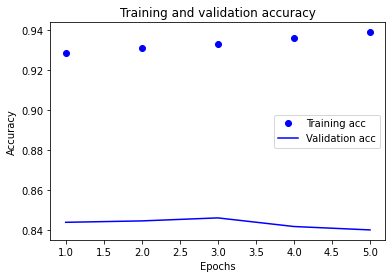

In [28]:
# Training and validation accuracy 그래프 그리기
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#b-3 CNN 모델의 test set 으로 평가

In [29]:
results = model_cnn.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 11s - loss: 0.6931 - accuracy: 0.4968
[0.6931374073028564, 0.49679598212242126]


In [ ]:
c-1 GlobalMaxPooling1D() 레이어 모델 훈련

In [30]:
# 모델 학습
model_glob.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_glob = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 6ms/step - loss: 0.1583 - accuracy: 0.9404 - val_loss: 0.5359 - val_accuracy: 0.8412
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1522 - accuracy: 0.9434 - val_loss: 0.5120 - val_accuracy: 0.8402
Epoch 3/5
266/266 [==============================] - 1s 6ms/step - loss: 0.1490 - accuracy: 0.9445 - val_loss: 0.5341 - val_accuracy: 0.8403
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1451 - accuracy: 0.9462 - val_loss: 0.5781 - val_accuracy: 0.8340
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.1403 - accuracy: 0.9479 - val_loss: 0.5940 - val_accuracy: 0.8395


In [ ]:
c-2 GlobalMaxPooling1D() 레이어 모델 Loss, Accuracy 그래프 시각화

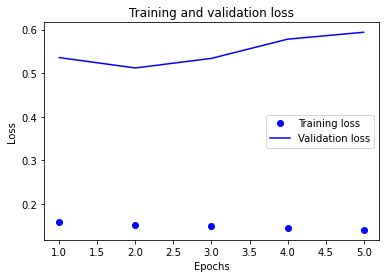

In [31]:
history_glob_dict = history_glob.history

# Training and validation loss 그래프 그리기
acc = history_glob_dict['accuracy']
val_acc = history_glob_dict['val_accuracy']
loss = history_glob_dict['loss']
val_loss = history_glob_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

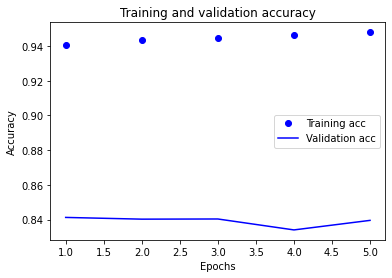

In [32]:
# Training and validation accuracy 그래프 그리기
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# c-3 GlobalMaxPooling1D() 레이어 모델의 test set 으로 평가

In [33]:
results = model_glob.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6933 - accuracy: 0.4982
[0.6933014988899231, 0.4981793165206909]


In [ ]:
##정확도 비교

In [ ]:
RNN : 0.8453
CNN : 0.4976
GlobalMaxPooling1D() 레이어 : 0.5051
RNN 모델의 정확도가 가장 높게 나왔다.

In [34]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
# 학습한 Embedding 파라미터를 파일에 써서 저장. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('명화', 0.9431427717208862),
 ('미소', 0.9422624111175537),
 ('잠기', 0.9422225952148438),
 ('소장', 0.9348759055137634),
 ('히트', 0.9339906573295593),
 ('사악', 0.9305805563926697),
 ('기타노', 0.9248445630073547),
 ('따라올', 0.9223556518554688),
 ('로빈윌리엄스', 0.9222946166992188),
 ('사로잡', 0.9193982481956482)]

In [ ]:
7. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
!pip install --upgrade gensim==3.8.3

In [ ]:
import gensim
from gensim.models import KeyedVectors
gensim.__version__

In [ ]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape     # 200dim의 워드 벡터

In [ ]:
word2vec.similar_by_word("가족")

In [ ]:
RNN 모델 생성

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_ko = tf.keras.Sequential()
model_ko.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(tf.keras.layers.MaxPooling1D(5))
model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(tf.keras.layers.GlobalMaxPooling1D())
model_ko.add(tf.keras.layers.Dense(8, activation='relu'))
model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_ko.summary()

In [ ]:
. 회고
영화리뷰를 전처리하여 분석하는 과정이 흥미러웠고 배웠던 이론을 실전에 적용하는 과정이 재미있었다.
영어를 넘어 한글을 적용해보는 경험을 통해 다양한 언어에 적용하는 방법을 배울 수 있었다.
여러가지 모델을 통해 학습 적용을 해 봄을 통해 다양한 모델에 대해 공부할 수 있었고
한국어 Word2Vec 임베딩 활용하여 성능 개선의 방법을 배울수 있었다.
하지만 적용한 결과 RNN에서는 정확도가 0.8453이 나왔지만
새로 모델을 적용한 결과 정확도가 0.8400로 오히려 줄어드는 결과가 나와서 당황하였다.
앞으로 원인을 찾고 새로운 개선방법을 공부해 볼 생각이다.